# Figure 5 (conditional leak model)
The goal of this model is to give a unified explanation to the two timescales observed in Fig. 4.

The model is intended to be phenomenological, but also biophysically plausible.

The model features a simple leaky integration unit, which represents the rate of behavior.

The time constant of the unit is gated by the existence of any inputs, such that it remembers more if it does not receive any motion input.

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import colorcet as cc
from homr_util import *
import random
from tqdm import tqdm

In [3]:
# Tweaking matplotlib 
set_rcParams()
# for exact reproduction of the data
random.seed(1)

## Model definition
### Parameters

In [4]:
dt = 0.1 # time resolution of the simulation (in seconds)

# time constants of the integrator units
tau_engaged = 2.7 # s
tau_disengaged = 15.0 # s

# bout rate
base_rate = 0.05
max_rate = 1.0
max_vel = 30 # saturating velocity in mm/s

# velocity related
engagement_threshold = 1.0 # mm/s

### Model functions
The leaky integrator follows the following dynamical equation:

$\dot{r} = -kr + u(t)$

where leak coefficient $k=1/\tau$.

$\tau$ is reduced if there is oncoming velocity inputs above certain threshold.

For the discrete simulation, because $\dot{r} = \frac{r(t)-r(t+dt)}{dt}$, we do

`r += (-r * (k1 + k2 *(u < threshold))) * dt`

where $k_1=1/\tau_1$ (faster $\tau$) and $k_1+k_2=1/\tau_2$ (slower $\tau$)




In [24]:
def drivemodel(dt, stim, tau1, tau2, threshold):
    '''
    Leaky integrator model with gated time constant
    Take stimulus time series as an input
    '''
    # activity variable ("drive")
    r = np.zeros(stim.shape)
    # convert time constants into coefficients in the dynamical equation
    k1 = 1/tau1
    k2 = (tau1 - tau2)/(tau1 * tau2)
    
    # run the dynamics
    for i in range(1, stim.shape[-1]):
        r[..., i] = r[..., i-1] + (-r[..., i-1]*(k1 + k2*(np.abs(stim[..., i])<threshold)) + stim[..., i])*dt
    
    return r

# Probabilistic bouting model
# Severi 2014 says in free swimming swimming effort saturates at 20 mm/s
# Do not implement refractory period now because I am lazy, just do uniform distribution
def boutmodel(dt, drive, base_rate, max_rate, gain=4):
    # calculate bout probability with sigmoid function
    # gain decides what is the exponent when max_vel is reached
    bout_rate_orig = 1 / (1 + np.exp(-(drive - max_vel/2) * gain / max_vel * 2))
    bout_rate = base_rate + (max_rate - base_rate) * bout_rate_orig
    bout = bout_rate*dt > np.random.rand(*drive.shape)
    return bout, bout_rate

## Simulation and Panels
### Noise correlation (as in Fig. 4A)

In [25]:
# parameters
noise_duration_min = 60
noise_flip_rate = 0.5 # Hz
noise_speed = 15 # mm/s
repeat = 50

In [26]:
# run the simulation once
t = np.arange(0, noise_duration_min * 60, dt)
s = noise_speed * (-1 + 2*(np.cumsum(np.random.rand(repeat, len(t)) < dt * noise_flip_rate, axis=-1) % 2))
r = drivemodel(dt, s, tau_engaged, tau_disengaged, engagement_threshold)
bout, bout_rate = boutmodel(dt, r, base_rate, max_rate, gain=2)

### Fig. 5B (Example time traces of the model during a simulated reverse correlation experiment)

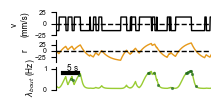

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(2,1))

# stimulus
ax[0].plot(t, s[0,:], 'k-') # stimulus
ax[0].plot(t, 0*t, 'k--')
ax[0].set_ylabel('v \n(mm/s)')
ax[0].set_ylim(-25,25)

# integrator value
ax[1].plot(t, r[0,:], color=(0.9, 0.6, 0.1)) # drive
ax[1].plot(t, 0*t, 'k--')
ax[1].set_ylabel('r')

# bout frequency, after nonlinearity
# with bouts plotted as dots
ax[2].plot(t, bout_rate[0,:], color=(0.6, 0.8, 0.2)) # probability
i_bout = np.where(bout[0, :])
ax[2].scatter(t[i_bout], bout_rate[0,i_bout], s=5, color=(0.1, 0.4, 0.1), zorder=3, alpha=0.7) # bout
ax[2].plot([2,7],[0.8,0.8],'k-',lw=3)
ax[2].set_ylim(0,1.1)
ax[2].set_ylabel('$\lambda_{bout}$ (Hz)')
ax[2].text(3.5, 0.9, '5 s')

for i, axx in enumerate(ax):
    axx.set_xlim((0,50))
    toggle_spines(axx, 0, 0, 0, 1)

plt.savefig('./svgs/Fig5B.svg', format='svg')
plt.show()

### Repeat the simulation and perform BTA extraction

In [28]:
# noise correlation (bout triggered average)
bta_duration = 15
bta = np.zeros((repeat, int(bta_duration/dt)))

for j in tqdm(range(repeat)):
    bout_ind = np.where(bout[j,:])[0]
    n_bout = len(bout_ind)
    for i in bout_ind:
        if i > bta.shape[-1]:
            bta[j, :] += s[j, i:i-bta.shape[-1]:-1] / n_bout

tau, beta, t_bta = fit_exponential(np.mean(bta,axis=0), bta_duration, 1/dt)

100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 128.84it/s]


### Fig. 5C (Individual and mean model BTA with exponential fit)

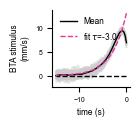

In [32]:
plt.figure(figsize=(1, 1))
plt.plot(-t_bta, bta.T, alpha=0.5, color=(0.8,0.8,0.8), lw=1)
plt.plot(-t_bta, t_bta*0, 'k--')
plt.plot(-t_bta, np.mean(bta,axis=0), color=(0, 0, 0), label='Mean')
plt.plot(-t_bta, np.exp(beta)*np.exp((bta_duration-t_bta)/tau), color=(0.9,0.2,0.6), label=r'fit $\tau$={:0.2}'.format(-tau), linestyle='--')
plt.xlabel('time (s)')
plt.ylabel('BTA stimulus\n(mm/s)')
toggle_spines(plt.gca(), 0, 1, 0, 1)
plt.legend()

plt.savefig('./svgs/Fig5C.svg', format='svg')
plt.show()

### Long wait experiment (as in FIg. 4E)

In [37]:
# stimulus parameters
t_s = np.arange(0, 35, dt)
speed = 5
wait_durations = np.arange(0,16)

# prepare stimuli
stim = []
for this_wait in wait_durations:
    pre_pulse = (t_s>5)*(t_s<8)
    pos_stim = pre_pulse*speed
    neg_stim = pre_pulse*(-speed)
    pos_stim[(t_s>8+this_wait)*(t_s<8+this_wait+10)] = +speed
    neg_stim[(t_s>8+this_wait)*(t_s<8+this_wait+10)] = +speed
    stim.append((pos_stim, neg_stim))
stim = np.asarray(stim)

# calculate drive and bout probability difference
resp = drivemodel(dt, stim, tau_engaged, tau_disengaged, engagement_threshold)
bout, p = boutmodel(dt, resp, base_rate, max_rate, gain=2)
p_diff = -np.diff(p, axis=1)

mean_p_diff = []
for i, this_wait in enumerate(wait_durations):
    mean_p_diff.append(np.mean(p_diff[i, 0, (t_s>8+this_wait)*(t_s<8+this_wait+10)]))

### Fig. 5D (Individual example showing model bout probability for each primimng direction)

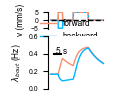

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(0.75, 1), height_ratios=(1,3))

labels = ('forward', 'backward')
k = 7
for j in range(2):
    ax[0].plot(t_s, stim[k][j], color=cc.cm.CET_D11(1.0-j), label=labels[j])
    ax[1].plot(t_s, p[k][j], color=cc.cm.CET_D11(1.0-j))
ax[0].plot(t_s, stim[k][0], '--', color=cc.cm.CET_D11(1.0))
ax[0].plot(t_s, 0*t_s, 'k--')
    
ax[0].set_ylabel('v (mm/s)')
ax[0].legend(loc='upper right')
   
ax[1].plot([2,7],[0.4,0.4],'k-',lw=1.5)
ax[1].set_ylabel('$\lambda_{bout}$ (Hz)')
ax[1].text(3.5, 0.4, '5 s')
ax[1].set_ylim(0, 0.6)

for i, axx in enumerate(ax):
    toggle_spines(axx, 0, 0, 0, 1)


plt.savefig('./svgs/Fig5D.svg', format='svg')
plt.show()

### Fig. 5E (Model bout probability difference by priming directions as a function of waiting duration)

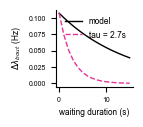

In [36]:
plt.figure(figsize=(1, 1))
plt.plot(wait_durations, mean_p_diff, 'k-', label='model')

# Also show the exponential from the reverse correlation
plt.plot(wait_durations, np.exp(-wait_durations/tau_engaged) * mean_p_diff[0], linestyle='--', color=(0.9,0.2,0.6), label='tau = 2.7s')

plt.xlabel('waiting duration (s)')
plt.ylabel('$\Delta\lambda_{bout}$ (Hz)')
plt.legend(loc='upper right')
toggle_spines(plt.gca(), 0, 1, 0, 1)

plt.savefig('./svgs/Fig5E.svg', format='svg')
plt.show()

### Wait with wave experiment

In [39]:
# stimulus parameters
t_s = np.arange(0, 35, dt)
speed = 5
wave_period = 2
wait_durations = np.arange(0, 12, 2)

# generate stimuli
stim_nw = []
stim_w = []
for this_wait in wait_durations:
    # first create "wave" during waiting
    wave = (speed * np.sin(t_s * np.pi * 2 / wave_period)) * ((t_s>8)*(t_s<8+this_wait))
    # add primimng and probe
    pre_pulse = (t_s>5)*(t_s<8)
    probe_pulse = (t_s>8+this_wait)*(t_s<8+this_wait+10)
    # register
    stim_nw.append((pre_pulse*speed + probe_pulse*speed, pre_pulse*(-speed) + probe_pulse*speed))    
    stim_w.append((pre_pulse*speed + probe_pulse*speed +wave, pre_pulse*(-speed) + probe_pulse*speed +wave))
# convert to numpy array
stim_w = np.asarray(stim_w)
stim_nw = np.asarray(stim_nw)

# run the model
resp_w = drivemodel(dt, stim_w, tau_engaged, tau_disengaged, engagement_threshold)
resp_nw = drivemodel(dt, stim_nw, tau_engaged, tau_disengaged, engagement_threshold)
_, p_w = boutmodel(dt, resp_w, base_rate, max_rate, gain=2)
_, p_nw = boutmodel(dt, resp_nw, base_rate, max_rate, gain=2)

# compare the bout probability
p_diff_w = -np.diff(p_w, axis=1)
p_diff_nw = -np.diff(p_nw, axis=1)

mean_p_diff_w = []
mean_p_diff_nw = []

for i, this_wait in enumerate(wait_durations):
    mean_p_diff_w.append(np.mean(p_diff_w[i, 0, (t_s>8+this_wait)*(t_s<8+this_wait+10)]))
    mean_p_diff_nw.append(np.mean(p_diff_nw[i, 0, (t_s>8+this_wait)*(t_s<8+this_wait+10)]))

### Fig. 5F (Individual example showing model bout probability for each primimng direction)

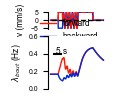

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(0.75, 1), height_ratios=(1,3))

labels = ('forward', 'backward')
k = 5

# stimulus
for j in range(2):
    ax[0].plot(t_s, stim_w[k][j], color=cc.cm.CET_D8(1.0-j), label=labels[j])
    ax[1].plot(t_s, p_w[k][j], color=cc.cm.CET_D8(1.0-j))
ax[0].plot(t_s, stim_w[k][0],  '--', color=cc.cm.CET_D8(1.0))
ax[0].plot(t_s, 0*t_s, 'k--')
ax[0].set_ylabel('v (mm/s)')
ax[0].legend(loc='upper right')

# model response
ax[1].plot([2,7],[0.4,0.4],'k-',lw=1.5)
ax[1].set_ylabel('$\lambda_{bout}$ (Hz)')
ax[1].text(3.5, 0.4, '5 s')
ax[1].set_ylim(0, 0.6)

for i, axx in enumerate(ax):
    toggle_spines(axx, 0, 0, 0, 1)

plt.savefig('./svgs/Fig5F.svg', format='svg')
plt.show()

### Fig. 5G (Model bout probability difference by priming directions as a function of waiting duration, w/o wave)

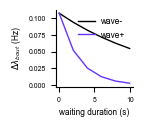

In [43]:
plt.figure(figsize=(1, 1))
plt.plot(wait_durations, mean_p_diff_nw, label='wave-', color=(0,0,0))
plt.plot(wait_durations, mean_p_diff_w, label='wave+', color=(0.4, 0.2, 1.0))

plt.xlabel('waiting duration (s)')
plt.ylabel('$\Delta\lambda_{bout}$ (Hz)')
toggle_spines(plt.gca(), 0, 1, 0, 1)
plt.legend()
plt.savefig('./svgs/Fig5G.svg', format='svg')
plt.show()